
<center>
<h1><font size="+3">Gold nanoparticle</font></h1>
</center>

---

<CENTER>
<H1 style="color:red">
Scattering properties of a single sphere from Mie calculation
</H1>
</CENTER>

## <font color='red'> Load modules </font>

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#import sys
#sys.path

#setting:

# Only 10 rows of data will be displayed
pd.set_option("max_rows", 10) 

# Print floating point numbers using fixed point notation
np.set_printoptions(suppress=True)

# Set figure size
#LARGE_FIGSIZE = (8, 6)

font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

## <font color='red'>Refractive index dataset</font>

- <a href="https://refractiveindex.info/?shelf=3d&book=metals&page=gold">Complex refractive index dataset(n+ik) for bulk gold </a>
- <a href="https://pubs.acs.org/doi/10.1021/ac0702084"> Correction of refractive index for small particle</a>


In [2]:
url = "https://refractiveindex.info/data_csv.php?datafile=data/main/Au/Rakic-BB.yml"
df1 = pd.read_csv(url)

#reorganize data
#original data with n and k in the same columne
index1=df1.index[df1.n=='k'].tolist()[0]
df2=df1[:index1].astype(float)
df2['k']=df1[index1+1:].n.values.astype('float')
df1=df2

#if data are downloaded and stored in local file
#df1=pd.read_csv('./Rakic-BB.csv')
#df1=df1.drop(columns=['wl.1'])
#df1.columns=["Wavelength", "n", "k"]

#change column name and use only wavelength less than 800nm
df1.columns=["Wavelength", "n", "k"]
df1.Wavelength=df1.Wavelength*1000
df1=df1[df1['Wavelength']<800]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 0 to 72
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wavelength  73 non-null     float64
 1   n           73 non-null     float64
 2   k           73 non-null     float64
dtypes: float64(3)
memory usage: 2.3 KB


In [3]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wavelength,73.0,470.141233,159.522011,247.97000,331.77000,443.9000,593.9300,794.6600
n,73.0,1.040926,0.640062,0.16897,0.25437,1.4126,1.6006,1.7411
k,73.0,2.398797,0.883586,1.74790,1.80070,1.9312,2.8493,4.6635


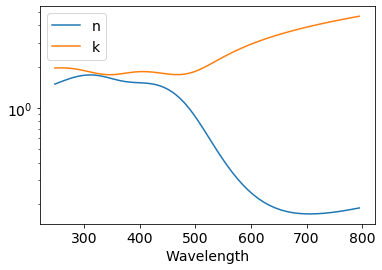

In [4]:
df1.plot(x='Wavelength', y=['n','k'],logy=True)
#df1.plot(subplots=True);

## <font color='red'>Python Mie Code </font>

- <a href="https://pymiescatt.readthedocs.io/en/latest/">PyMieScatt: Python Mie code document</a>
- <a href="https://www.sciencedirect.com/science/article/pii/S0022407317305836">PyMieScatt reference</a>
- Installation through conda: conda install -c conda-forge pymiescatt
- Note that the input value for MieQ is wavelength and particle diameter. 

In [5]:
import PyMieScatt as ps

#test one case
wavelength=375
diameter=300
nc=1.77+0.63j #complex refractive index
ps.MieQ(nc,wavelength, diameter,asDict=True) 
#check it is diameter of radius?

{'Qext': 2.8584971991564117,
 'Qsca': 1.3149276685170943,
 'Qabs': 1.5435695306393173,
 'g': 0.7251162362148784,
 'Qpr': 1.905021797266491,
 'Qback': 0.20145510481352577,
 'Qratio': 0.1532062254349824}

The definitions of the output quantities are documented in https://pymiescatt.readthedocs.io/en/latest/forward.html. Specifically $Q_{back}$ is defined as
![title](../img/t01_PyMieScatt_Q.png)
This is the 180 deg backscattering (radar cross section or lidar cross section).

### multiple size and wavelength

In [6]:
df2=df1
#wavelength follow the input file
#convert to nm
wv=df2.Wavelength[::1].values
#n array
nv=df2.n[::1].values
#k array
kv=df2.k[::1].values
#diameter array
dv=np.array(range(30,160,10))

nwv=len(wv)
nd=len(dv)
print("number of wavelength: %i, number of diamters: %i" %(nwv, nd))

number of wavelength: 73, number of diamters: 13


In [7]:
def run_mie(nv, kv, wv, dv):
    nd=len(dv)
    nwv=len(wv)
    
    #run the mie code for above parameters
    miev=np.array([[ps.MieQ(nv[i]+kv[i]*1.0j,wv[i],dv[j],asDict=True) \
                    for j in range(nd)] \
                   for i in range(nwv)])

    qextv=np.array([[miev[i,j]['Qext'] for j in range(nd)]for i in range(nwv)])
    qscav=np.array([[miev[i,j]['Qsca'] for j in range(nd)]for i in range(nwv)])
    qabsv=np.array([[miev[i,j]['Qabs'] for j in range(nd)]for i in range(nwv)])
    qbackv=np.array([[miev[i,j]['Qback'] for j in range(nd)]for i in range(nwv)])
    gv=np.array([[miev[i,j]['g'] for j in range(nd)]for i in range(nwv)])

    return [qextv,qscav, qabsv, qbackv,gv]

def plot_q(datav,  wv, dv,fileout, figsize=(12,9)):
    [qextv,qscav,qabsv,qbackv, gv]=datav
    plt.figure(figsize=figsize)
    nd=len(dv)
    nwv=len(wv)
    num_plots=len(dv)

    colormap = plt.cm.gist_ncar


    ax=plt.subplot(231)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    ax.set_yscale('log')
    for j in range(nd):
        tmp=plt.plot(wv,qextv[:,j], label=dv[j])

    plt.xlabel("Wavelength(nm)")
    plt.ylabel("$Q_{ext}$")
    
    ax=plt.subplot(232)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    ax.set_yscale('log')
    for j in range(nd):
        tmp=plt.plot(wv,qscav[:,j], label=str(dv[j])+'nm')
    plt.ylabel("$Q_{sca}$")
    plt.xlabel("Wavelength(nm)")
    
    
    ax=plt.subplot(233)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    ax.set_yscale('log')
    for j in range(nd):
        tmp=plt.plot(wv,qscav[:,j]/qextv[:,j], label=str(dv[j])+'nm')
    plt.ylabel("$SSA$")
    plt.xlabel("Wavelength(nm)")
    
    ax=plt.subplot(234)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    ax.set_yscale('log')
    for j in range(nd):
        tmp=plt.plot(wv,qabsv[:,j], label=str(dv[j])+'nm')
    plt.ylabel("$Q_{abs}$")
    plt.xlabel("Wavelength(nm)")

    ax=plt.subplot(235)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    ax.set_yscale('log')
    for j in range(nd):
        tmp=plt.plot(wv,qbackv[:,j], label=str(dv[j])+'nm')
    plt.ylabel("$Q_{back}$")
    plt.xlabel("Wavelength(nm)")
    
    ax=plt.subplot(236)
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))

    #ax.set_yscale('log')
    for j in range(nd):
        tmp=plt.plot(wv,gv[:,j], label=str(dv[j])+'nm')
    plt.ylabel("Asymmetry factor")
    plt.xlabel("Wavelength(nm)")
    plt.legend(bbox_to_anchor=(1.3,1.2),title="Diameter")
    
    plt.tight_layout()
    

    plt.savefig(fileout)

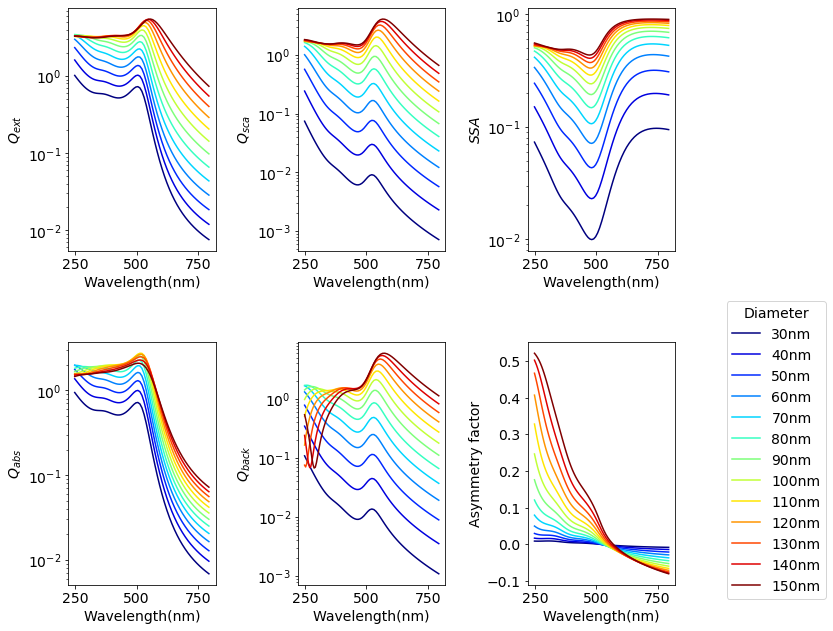

In [8]:
datav=run_mie(nv, kv, wv, dv)

fileout='/Users/mgao1/Desktop/gold_nanoparticle.pdf'
plot_q(datav, wv, dv, fileout)

### Comparing with literature with correction of refrative index

Smalller size of gold nanoparticles need correction of the bulk refractive index. The corrections are discussed in <a href="https://pubs.acs.org/doi/10.1021/ac0702084"> Haiss et al, Anal. Chem. 2007, 79, 4215-4221  </a>.
The correction is significant for diameter < 15nm ((Figure 3). We can have a comparison of the $Q_{ext}$ to the more rigor method in Haiss et al's paper Figure 4a. We have good agreement. 

![title](../img/t01_Haiss_figures.png)

Image Source: <a href="https://pubs.acs.org/doi/10.1021/ac0702084"> Haiss et al, Anal. Chem. 2007, 79, 4215-4221 </a>

### Interpolate wavelength for more regular grids

Here we interpolate the wavelength into a set of values we want.

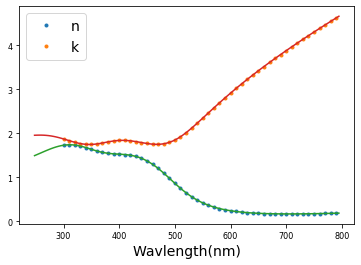

In [243]:
from scipy.interpolate import interp1d

wv=df2.Wavelength[::1].values
#n array
nv=df2.n[::1].values
#k array
kv=df2.k[::1].values

fn = interp1d(df2.Wavelength, df2.n)
fk = interp1d(df2.Wavelength, df2.k)

#interpolate to regular wavelength scale
#wv2=np.linspace(250,790,55)
wv2=np.linspace(300,790,50)
nv2=fn(wv2)
kv2=fk(wv2)

plt.plot(wv2, nv2,'.', label='n')
plt.plot(wv2, kv2,'.', label='k')
plt.plot(wv, nv)
plt.plot(wv, kv)
plt.xlabel("Wavlength(nm)")
plt.legend()

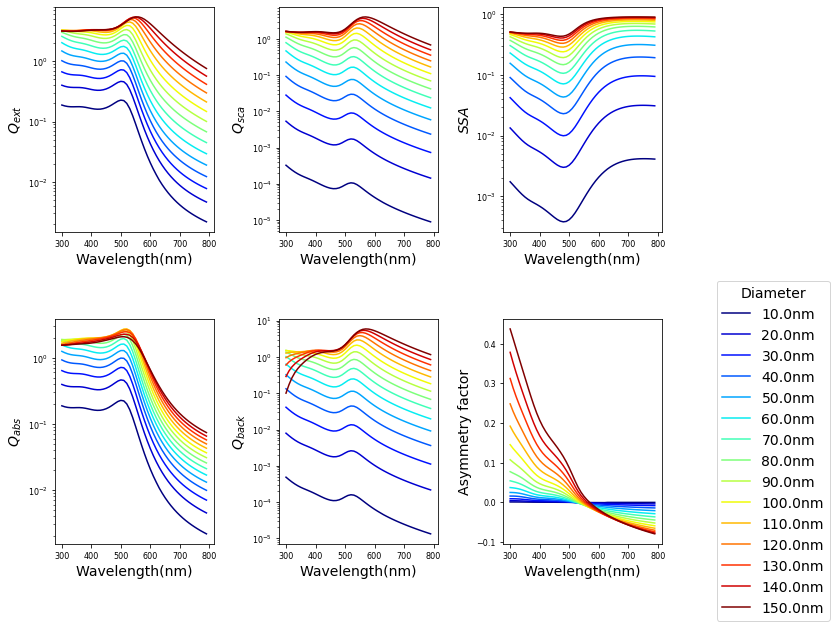

In [261]:
#dv=np.linspace(30,150,13)
dv2=np.linspace(10,150,15)
#dv=np.linspace(10,100,10)
#dv=np.array([2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90,100])
datav=run_mie(nv2, kv2, wv2, dv2)
pickle.dump([nv2, kv2, wv2, dv2, datav], open("../data/gold_mie.pkl", "wb" ))

fileout='/Users/mgao1/Desktop/gold_nanoparticle2.pdf'
plot_q(datav, wv2,dv2, fileout)

In [263]:
def save_for_mstm(nv2, kv2, wv2, dv2):

    def sp(dv,wv):
        return np.pi*dv/wv
    
    nkd=np.array([[wv2[iwv], nv2[iwv],kv2[iwv], \
                   sp(dv2[0],wv2[iwv]), \
                   sp(dv2[-1],wv2[iwv]), 
                   sp(dv2[1]-dv2[0],wv2[iwv])] for iwv in range(len(wv2))])
    #, kv2[iwv], xdv[0], xdv[-1], xdv[1]-xdv[0]]
    print(nkd.shape)

    pickle.dump([nv2, kv2, wv2, dv2, nkd], open("../data/gold_nk.pkl", "wb" ))

In [264]:
save_for_mstm(nv2, kv2, wv2, dv2)

(50, 6)


## todo 

In [ ]:
#clean the plot function
```python
fig = plt.figure()
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8)
subcol=2
subrow=2
counter=1
handles = []
for title in a[1:]:

        ax = fig.add_subplot(subcol,subrow,counter)
        l1 = ax.plot(x,line[:4],marker='o', color='r', label = 'oral')
        l2 = ax.plot(x,line[4:],marker='o', color='b',label = 'physa')
        if not handles:
           handles = [l1, l2]
        ax.set_title(title,fontsize = 10)
        counter+=1

fig.legend(handles, ['oral', 'physa'], bbox_to_anchor=(2, 0),loc = 'lower right')
plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
plt.suptitle('Kegg hedgehog',size=16)
plt.show()